In [ ]:
!pip install mkdir
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.05G/1.06G [02:01<00:00, 113MB/s]
100% 1.06G/1.06G [02:01<00:00, 9.37MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/contnt')
zip_ref.close()

**PYAPARK IMPLEMENTATION**

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 48 kB/s 
     |████████████████████████████████| 199 kB 72.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=5b3ac34426ee06267655795069d53452eb789dd6d97d5838af52f63e19bf402e
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
# Data Frame spark profiling 
from pyspark.sql.types import IntegerType, StringType, DoubleType, ShortType, DecimalType
import pyspark.sql.functions as func
from pyspark.sql.functions import isnull
from pyspark.sql.functions import isnan, when, count, col, round
from pyspark.sql.functions import mean
from pyspark.sql.types import Row
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf

# Pandas DF operation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array

# Modeling + Evaluation
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
from pyspark.sql import functions as F
from pyspark.sql.functions import avg
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
from pyspark.sql import Window
from pyspark.sql.functions import rank,sum,col
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorSlicer

# window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

In [ ]:
!pip install petastorm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 285 kB 33.8 MB/s 
     |████████████████████████████████| 44 kB 3.8 MB/s 


In [ ]:
import os, sys
import numpy as np

from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructField, StructType, IntegerType, BinaryType, StringType, TimestampType

from petastorm.etl.dataset_metadata import materialize_dataset
from petastorm.codecs import ScalarCodec, CompressedImageCodec, NdarrayCodec
from petastorm.unischema import dict_to_spark_row, Unischema, UnischemaField

ROWGROUP_SIZE_MB = 128 # The same as the default HDFS block size

# The schema defines how the dataset schema looks like
ImageSchema = Unischema('ImageSchema', [
    UnischemaField('path', np.string_, (), ScalarCodec(StringType()), False),
    UnischemaField('image', np.uint8, (1080, 1280, 3), CompressedImageCodec('png'), False)
])


output_url = "file:///tmp/petastorm_ingest_test"
rows_count = 1

def ingest_folder(images_folder, spark):

    image_files = "file:///"+os.path.abspath(images_folder)+"/*.png"
    print(image_files)
    # Read all images at once
    image_df = spark.read.format("image").load(image_files)

    print('Schema of image_df')
    print('--------------------------')
    image_df.printSchema()

    with materialize_dataset(spark, output_url, ImageSchema, ROWGROUP_SIZE_MB):
        
        set_df = image_df.select(image_df.image.origin.alias('path'), image_df.image.data.alias('image'))

        print('Schema of set_df')
        print('--------------------------')
        set_df.printSchema()
        print(ImageSchema.as_spark_schema())
        
        print('Saving to parquet')

        """
        set_df.write \
                .mode('overwrite') \
                .parquet(output_url)
        
        """
        
        spark.createDataFrame(set_df.rdd, ImageSchema.as_spark_schema()) \
            .coalesce(10) \
            .write \
            .mode('overwrite') \
            .parquet(output_url)

def main():

    # Start the Spark session
    spark = SparkSession.builder.config('spark.driver.memory', '2g').master('local[*]').getOrCreate()    
    sc = spark.sparkContext

    # Ingest images and annotations for a given folder
    ingest_folder("../images/", spark)

    main()

**CNN MODEL IMPLEMENTATION**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [ ]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [ ]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
# create CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     256       
 hNormalization)                                                 
                                                        

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 82s 115ms/step - loss: 1.5185 - accuracy: 0.5867 - val_loss: 0.6239 - val_accuracy: 0.6600
Epoch 2/10
625/625 [==============================] - 72s 115ms/step - loss: 0.5582 - accuracy: 0.7128 - val_loss: 0.5238 - val_accuracy: 0.7370
Epoch 3/10
625/625 [==============================] - 72s 115ms/step - loss: 0.5148 - accuracy: 0.7522 - val_loss: 0.4847 - val_accuracy: 0.7694
Epoch 4/10
625/625 [==============================] - 72s 115ms/step - loss: 0.4310 - accuracy: 0.8011 - val_loss: 0.5148 - val_accuracy: 0.7402
Epoch 5/10
625/625 [==============================] - 72s 115ms/step - loss: 0.3636 - accuracy: 0.8408 - val_loss: 0.4910 - val_accuracy: 0.7570
Epoch 6/10
625/625 [==============================] - 72s 115ms/step - loss: 0.2926 - accuracy: 0.8800 - val_loss: 0.6679 - val_accuracy: 0.7198
Epoch 7/10
625/625 [==============================] - 72s 115ms/step - loss: 0.2214 - accuracy: 0.9090 - val_loss: 0.5324 - val_ac

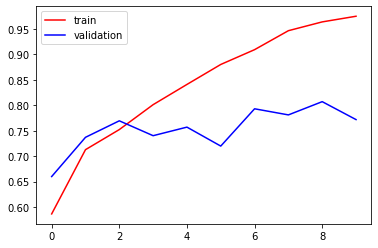

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

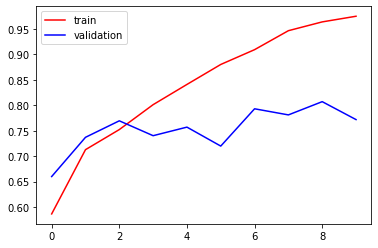

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

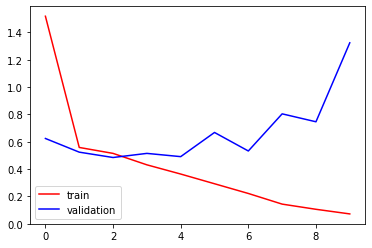

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

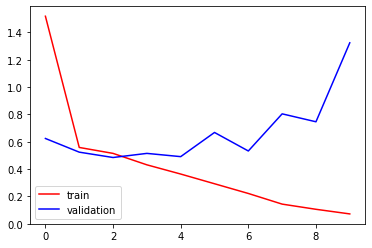

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# ways to reduce overfitting

# Add more data
# Data Augmentation 
# L1/L2 Regularizer
# Dropout
# Batch Norm
# Reduce complexity

In [ ]:
import cv2

In [ ]:
test_img = cv2.imread('/content/Dog.jpg')

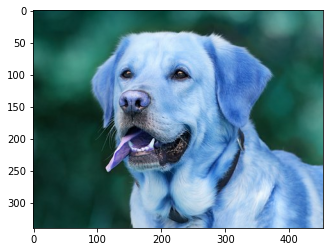

In [ ]:
plt.imshow(test_img)

In [ ]:
test_img = cv2.resize(test_img,(256,256))

In [ ]:
test_input = test_img.reshape((1,256,256,3))

In [ ]:
model.predict(test_input)

1/1 [==============================] - 0s 241ms/step


array([[1.]], dtype=float32)